In [17]:
import os
import yaml
import time
import numpy as np
import pandas as pd
import shelve
import sys
import threading
sys.path.append('../../GEECS-PythonAPI')
from geecs_python_api.controls.interface import GeecsDatabase
from geecs_python_api.controls.devices.geecs_device import GeecsDevice

GeecsDevice.exp_info = GeecsDatabase.collect_exp_info("Undulator")

In [18]:
# set up the python objects for the geecs devices to be used in optimization
hexapod = GeecsDevice('U_Hexapod')
# hexapod.subscribe_var_values(['xpos', 'ypos'])



# define a dict containing the specific variables and bounds to be used in optimization
objs={'HexY':{"GEECS_Object":hexapod,'variable':"ypos","bounds":[17,19]},
    'HexZ':{"GEECS_Object":hexapod,'variable':"zpos","bounds":[-.4,1]},
      'HexV':{"GEECS_Object":hexapod,'variable':"vangle","bounds":[-.4,.1]},
     'HexW':{"GEECS_Object":hexapod,'variable':"wangle","bounds":[-.4,.1]}}

In [4]:
# for i in range(20):
#     start_time = time.time()  # Record the start time
#     time.sleep(2)
#     print(hexapod.get_status())
#     # print(f'{hexapod.get_name()} state:\n\t{hexapod.get_status()}')
#     print(hexapod.state)
#     end_time = time.time()  # Record the end time
#     elapsed_time = end_time - start_time  # Calculate elapsed time
#     print(f"Iteration {i+1} took {elapsed_time:.4f} seconds.")
    

# values = []

# for i in range(5):
#     # Wait for a fresh value
#     while not hexapod.state['fresh']:
#         time.sleep(0.05)  # Sleep for a short interval before checking again
#         print(hexapod.state['fresh'])

#     # Fetch the fresh xpos value
#     value = hexapod.state['xpos']
    
#     # Append the value to the list
#     values.append(value)
    
#     # Indicate that the current state has been read
#     hexapod.state['fresh'] = False

# hexapod.unsubscribe_var_values()

hexapod.state
hexapod.unsubscribe_var_values()
hexapod.close()

In [5]:

objective_dict = {'var1':{"device_name":"UC_Amp2_IR_input","device_subscribe_variables":['MeanCounts','MaxCounts']}}  

devices = {}  # A dictionary to store the created GeecsDevice objects
for key in objective_dict:
    device_name = objective_dict[key]['device_name']
    device_variables = objective_dict[key]['device_subscribe_variables']

    new_device = GeecsDevice(device_name)  # Assuming GeecsDevice takes the device_name as an argument
    new_device.use_alias_in_TCP_subscription=False
    new_device.subscribe_var_values(device_variables)

    devices[key] = new_device  # Store the new device in the devices dictionary


In [4]:
devices['var1'].state

{'fresh': True,
 'Device Status': 'no scan',
 'device error': '',
 'device preset': '',
 'MeanCounts': 0.927924,
 'MaxCounts': 11.0}

In [12]:
state=devices['var1'].state
state.get('MeanCounts')

0.930604

In [19]:
#define whether or not to use normalized values and ranges for optimization controls. 
#Normalization seems like a good idea
normalize=False

#for opt method, choose nelder or bayes for now
opt_method='bayes'

#define the xopt configuration
YAML = """
xopt:
    dump_file: dump.yaml
generator:
    name:
    gp_constructor:
        use_low_noise_prior: false
    
evaluator:
    function: __main__.geecs_measurement

vocs:
    variables:
    objectives: {f: "MAXIMIZE"}

"""

yaml_output = yaml.safe_load(YAML)

if opt_method == 'bayes':
    yaml_output['generator']['name'] = 'upper_confidence_bound'
    yaml_output['generator']['n_initial'] = 2
    yaml_output['generator']['acq'] = {'beta':0.1}
    yaml_output['xopt']['dump_file'] = 'bayes.yaml'
elif opt_method == 'nelder':
    yaml_output['generator']['name'] = 'neldermead'
    yaml_output['generator']['adaptive'] = True
    yaml_output['generator']['xatol'] = 0.01
    yaml_output['generator']['fatol'] = 0.005
    yaml_output['generator']['initial_point'] = { "HexY":18.0,"HexZ":0.1,"HexV":0,"HexW":0}
    yaml_output['xopt']['dump_file'] = 'nelder.yaml'

#define some functions to normalize/unnormalize real variables to [-1,1]
def unnormalize_var(obj,val):
    range=objs[obj]['bounds'][1]-objs[obj]['bounds'][0]
    offset=objs[obj]['bounds'][0]
    new_val=(val/2+0.5)*range+offset
    return new_val

def normalize_var(obj,val):
    range=objs[obj]['bounds'][1]-objs[obj]['bounds'][0]
    offset=objs[obj]['bounds'][0]
    new_val=((val - offset)/range - 0.5)*2
    return new_val
    

for tag in objs.keys():
    yaml_output['vocs']['variables'][tag]=objs[tag]['bounds']
    
if normalize:
    for tag in objs.keys():
        yaml_output['vocs']['variables'][tag]=[-1.0,1.0]
    keys = yaml_output['vocs']['variables'].keys()
    

if yaml_output['generator']['name']=='neldermead':
    if normalize:
        initial_point = yaml_output['generator']['initial_point']

        normalized_initial_point = {}
        for key in keys:
            normalized_initial_point[key] = normalize_var(key, initial_point[key])

        yaml_output['generator']['initial_point'] = normalized_initial_point

print(yaml_output)

TypeError: 'NoneType' object does not support item assignment

In [29]:
YAML = """
generator: 
  name: upper_confidence_bound
  beta: 0.1
  
evaluator:
  function: __main__.geecs_measurement

vocs:
  variables:
    hexy: [17,19]
    hexz: [-.4,1]
    hexw: [-.4,1]
    hexv: [-.4,1]
  objectives: {f: "MAXIMIZE"}
"""
  gp_constructor:
    use_low_noise_prior: false
# # Make a proper input file.
# YAML = """
# generator:
#   name: upper_confidence_bound
#   beta: 0.1

# evaluator:
#   function: xopt.resources.test_functions.sinusoid_1d.evaluate_sinusoid

# vocs:
#   variables:
#     x1: [0, 6.28]
#   objectives:
#     y1: 'MINIMIZE'
# """


yaml_output = yaml.safe_load(YAML)

yaml_string = yaml.dump(yaml_output)
print(yaml_string)

evaluator:
  function: __main__.geecs_measurement
generator:
  beta: 0.1
  name: upper_confidence_bound
vocs:
  objectives:
    f: MAXIMIZE
  variables:
    hexv:
    - -.4
    - 1
    hexw:
    - -.4
    - 1
    hexy:
    - 17
    - 19
    hexz:
    - -.4
    - 1



In [45]:
#simulate transmission of blue diode through PMQ triplet
import numpy as np

optPosition = np.array([18.45, 0.6])
numParts = 200000

startDist = np.transpose([
    np.random.normal(optPosition[0], 0.4, numParts),
    np.random.normal(optPosition[1], 0.4, numParts)
])

def calcTransmission(input_dict):
    center1 = [input_dict['HexY'], input_dict['HexZ']]
    separation = 15

    center2 = [input_dict['HexY'], input_dict['HexZ']]
    rotw = np.pi / 180 * (input_dict['HexW'] + 0.15) * 4
    rotv = np.pi / 180 * (input_dict['HexV'] + 0.25) * 4

    yOffset = separation * np.tan(rotw)
    zOffset = separation * np.tan(rotv)

    center2[0] = center2[0] + yOffset
    center2[1] = center2[1] + zOffset

    dist = startDist[
        (np.sqrt((startDist[:, 0] - center1[0])**2 + (startDist[:, 1] - center1[1])**2) < 0.2) &
        (np.sqrt((startDist[:, 0] - center2[0])**2 + (startDist[:, 1] - center2[1])**2) < 0.2)
    ]
    
    random_number_normal = np.random.normal(0, 0.0015)

    return len(dist) / numParts +random_number_normal+2.1

In [46]:
def geecs_measurement(input_dict):
    for i in list(input_dict.keys()):
        set_val=float(input_dict[i])
        if normalize:
            set_val=unnormalize_var(i,set_val)
        
        print('set '+str(i)+' to '+str(set_val))
        
        #line below executes the set commands.
        #objs[i]["GEECS_Object"].set(objs[i]["variable"],set_val)
        time.sleep(0)
        
    if normalize:
        setpoint = {}
        for key in input_dict:
            setpoint[key] = unnormalize_var(key, input_dict[key])
    else:
        setpoint=input_dict
        
    print(setpoint)
    values=[]
    for i in range(10):
        value=calcTransmission(setpoint)
        values.append(value)

    return {'f': np.array(values)}


In [47]:
# if opt_method == 'nelder':
#     geecs_measurement(yaml_output['generator']['initial_point'])
    
# geecs_measurement(yaml_output['generator']['initial_point'])
YAML = """
dump_file: dumpv2.yaml
generator:
  beta: 0.1
  computation_time: null
  fixed_features: null
  gp_constructor:
    name: standard
    covar_modules: {}
    mean_modules: {}
    use_low_noise_prior: false
  max_travel_distances: null
  model: null
  n_candidates: 1
  n_monte_carlo_samples: 128
  name: upper_confidence_bound
  numerical_optimizer:
    max_iter: 2000
    n_restarts: 20
    name: LBFGS
  supports_batch_generation: true
  turbo_controller: null
  use_cuda: false
evaluator:
  function: __main__.geecs_measurement
vocs:
  variables:
    HexY: [17,19]
    HexZ: [-.4,1]
    HexW: [-.4,1]
    HexV: [-.4,1]
  objectives: {f: "MAXIMIZE"}
"""

# YAML = """
# generator:
#   name: neldermead
#   initial_point: {x0: -1, x1: -1}
#   adaptive: true
#   xatol: 0.0001
#   fatol: 0.0001  
# evaluator:
#   function: xopt.resources.test_functions.rosenbrock.evaluate_rosenbrock
# vocs:
#   variables:
#     HexY: [17,19]
#     HexZ: [-.4,1]
#     HexW: [-.4,1]
#     HexV: [-.4,1]
#   objectives: {y: MINIMIZE}
# """

yaml_output = yaml.safe_load(YAML)

yaml_string = yaml.dump(yaml_output)


In [48]:
from xopt.evaluator import Evaluator
from xopt.generators.bayesian import ExpectedImprovementGenerator
from xopt import Xopt

X = Xopt.from_yaml(yaml_string)
X


            Xopt
________________________________
Version: 2.0.1
Data size: 0
Config as YAML:
dump_file: dumpv2.yaml
evaluator:
  function: __main__.geecs_measurement
  function_kwargs: {}
  max_workers: 1
  vectorized: false
generator:
  beta: 0.1
  computation_time: null
  fixed_features: null
  gp_constructor:
    covar_modules: {}
    mean_modules: {}
    name: standard
    trainable_mean_keys: []
    use_low_noise_prior: false
  max_travel_distances: null
  model: null
  n_candidates: 1
  n_monte_carlo_samples: 128
  name: upper_confidence_bound
  numerical_optimizer:
    max_iter: 2000
    n_restarts: 20
    name: LBFGS
  supports_batch_generation: true
  turbo_controller: null
  use_cuda: false
max_evaluations: null
serialize_inline: false
serialize_torch: false
strict: true
vocs:
  constants: {}
  constraints: {}
  objectives:
    f: MAXIMIZE
  observables: []
  variables:
    HexV:
    - -0.4
    - 1.0
    HexW:
    - -0.4
    - 1.0
    HexY:
    - 17.0
    - 19.0
    HexZ:
 

In [134]:
if opt_method == 'bayes':
    X.random_evaluate(3)

import torch
import matplotlib.pyplot as plt
n_steps = 30

for i in range(n_steps):
    print('step'+str(i))
    X.step()
    


set HexV to 0.6491005121792393
set HexW to 0.5885794843409774
set HexY to 18.484333372149845
set HexZ to 0.2601278302049829
{'HexV': 0.6491005121792393, 'HexW': 0.5885794843409774, 'HexY': 18.484333372149845, 'HexZ': 0.2601278302049829}
set HexV to 0.9879200142978214
set HexW to 0.1492002458350617
set HexY to 17.316514546663896
set HexZ to 0.11566088923410484
{'HexV': 0.9879200142978214, 'HexW': 0.1492002458350617, 'HexY': 17.316514546663896, 'HexZ': 0.11566088923410484}
set HexV to -0.06806419918815726
set HexW to 0.382361438401873
set HexY to 18.91994488334141
set HexZ to 0.11270576576513519
{'HexV': -0.06806419918815726, 'HexW': 0.382361438401873, 'HexY': 18.91994488334141, 'HexZ': 0.11270576576513519}
step0
set HexV to -0.2524960865649549
set HexW to -0.14897661127359021
set HexY to 18.440584180763352
set HexZ to 0.6389506689293902
{'HexV': -0.2524960865649549, 'HexW': -0.14897661127359021, 'HexY': 18.440584180763352, 'HexZ': 0.6389506689293902}
step1
set HexV to -0.252393035186573

In [135]:
type(X.data)
df=X.data
last_row_series = df.iloc[-1]
control_values = last_row_series[yaml_output['vocs']['variables'].keys()]  # control_names is a list of your control column names
f_value = last_row_series['f']
last_row_dict = df.iloc[-1].to_dict()
last_row_dict
X.data
# x = df['f']

,HexV,HexW,HexY,HexZ,f,xopt_runtime,xopt_error
0,-0.365109,-0.046050,18.562182,0.326908,2.137662,0.017684,False
1,-0.365109,-0.046050,18.562182,0.326908,2.136638,0.017684,False
2,-0.365109,-0.046050,18.562182,0.326908,2.141224,0.017684,False
3,-0.365109,-0.046050,18.562182,0.326908,2.13786,0.017684,False
4,-0.365109,-0.046050,18.562182,0.326908,2.139678,0.017684,False
...,...,...,...,...,...,...,...
655,-0.248398,-0.148434,18.423320,0.628281,2.2165,0.013746,False
656,-0.248398,-0.148434,18.423320,0.628281,2.214296,0.013746,False
657,-0.248398,-0.148434,18.423320,0.628281,2.217505,0.013746,False
658,-0.248398,-0.148434,18.423320,0.628281,2.217097,0.013746,False


{'HexV': -0.25246333517672065,
 'HexW': -0.14844606999054186,
 'HexY': 18.42442759394162,
 'HexZ': 0.6232367634309425,
 'f': 2.2203724906148796,
 'xopt_runtime': 0.013594666961580515,
 'xopt_error': False}

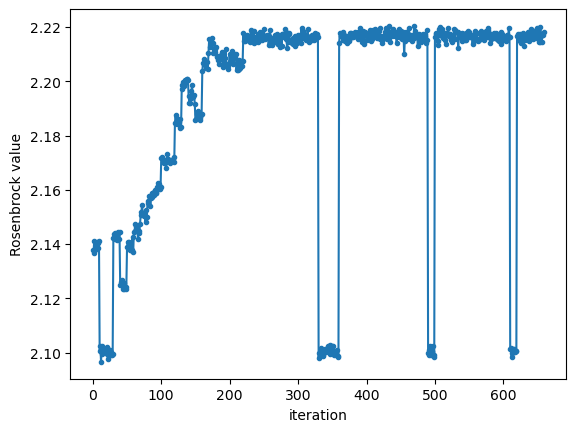

In [136]:
import matplotlib.pyplot as plt
X.data['f'].plot(marker='.')
# plt.yscale('log')
plt.xlabel('iteration')
plt.ylabel('Rosenbrock value')
best=dict(X.data.iloc[X.data["f"].argmax()]);

if normalize:
    for key in yaml_output['vocs']['variables'].keys():
        best[key] = unnormalize_var(key, best[key])

best

In [137]:
model1=X.generator.model
model1
noise = model1.models[0].likelihood.noise_covar.noise.squeeze().tolist()
mean_value = model1.models[0].mean_module.constant.squeeze().tolist()
outputscale = model1.models[0].covar_module.outputscale.squeeze().tolist()
lengthscale = model1.models[0].covar_module.base_kernel.lengthscale.squeeze().tolist()

print(f"Noise: {noise}")
print(f"Mean Value: {mean_value}")
print(f"Outputscale: {outputscale}")
print(f"Lengthscale: {lengthscale}")


Noise: 0.0014531356263841886
Mean Value: -2.3195261734692187
Outputscale: 1.407638778793032
Lengthscale: [0.18648111720744096, 0.10730224102281079, 0.43075083012607945, 0.6408926123448273]


In [138]:
# def extract_parameters(module, prefix=''):
#     params = {}
#     for name, param in module.modules():
#         raw_value = param.detach().cpu().numpy()
        
#         # Transform the raw values if a constraint exists
#         if hasattr(param, 'constraint') and param.constraint is not None:
#             transformed_value = param.constraint.transform(param).detach().cpu().numpy()
#         else:
#             transformed_value = raw_value  # If no transformation, the transformed value is the same as raw
        
#         params[name + "_raw"] = raw_value
#         params[name + "_transformed"] = transformed_value

#     for name, child in module.named_children():
#         child_params = extract_parameters(child, prefix=f"{prefix}.{name}" if prefix else name)
#         params.update(child_params)
#     return params

def extract_parameters(module, prefix=''):
    params = {}
    for name, param in module.named_parameters(prefix=prefix):  # Use named_parameters here
        raw_value = param.detach().cpu().numpy()
        
        # Transform the raw values if a constraint exists
        if hasattr(param, 'constraint') and param.constraint is not None:
            transformed_value = param.constraint.transform(param).detach().cpu().numpy()
        else:
            transformed_value = raw_value  # If no transformation, the transformed value is the same as raw
        
        params[name + "_raw"] = raw_value
        params[name + "_transformed"] = transformed_value

    for name, child in module.named_children():
        child_params = extract_parameters(child, prefix=f"{prefix}.{name}" if prefix else name)
        params.update(child_params)
    return params

def extract_hyperparameters_from_generic_model(model):
    hyperparameters = {}

    # Iterate over the models in the ModelListGP
    for idx, gp_model in enumerate(model.models):
        model_data = extract_parameters(gp_model)
        hyperparameters[f"model_{idx}"] = model_data

    return hyperparameters

def nested_dict_from_flat(d):
    """Convert flat dictionary with dot-separated keys into a nested dictionary."""
    out = {}
    for key, value in d.items():
        # Convert numpy arrays to Python lists
        if isinstance(value, np.ndarray):
            value = value.tolist()

        # If it's a list with a single value, flatten it
        if isinstance(value, list) and len(value) == 1:
            value = value[0]

        # If it's a nested list like [[1,2,3,4]], extract the inner list
        if isinstance(value, list) and len(value) == 1 and isinstance(value[0], list):
            value = value[0]
        
        keys = key.split('.')[1:]  # Skip the first element
        temp = out
        for k in keys[:-1]:
            temp = temp.setdefault(k, {})
        temp[keys[-1]] = value
    return out

# Assuming you've instantiated your ModelListGP as 'model'
hyperparameters = extract_hyperparameters_from_generic_model(model1)
print(hyperparameters)

# Assuming the flat structure is in the variable 'hyperparameters'
nested_hyperparameters = {k: nested_dict_from_flat(v) for k, v in hyperparameters.items()}

# Convert the nested dictionary to a YAML string
yaml_string = yaml.dump(nested_hyperparameters, default_flow_style=False)

print(yaml_string)


{'model_0': {'likelihood.noise_covar.raw_noise_raw': array([0.00145314]), 'likelihood.noise_covar.raw_noise_transformed': array([0.00145314]), 'mean_module.raw_constant_raw': array(-2.31952617), 'mean_module.raw_constant_transformed': array(-2.31952617), 'covar_module.raw_outputscale_raw': array(1.12697146), 'covar_module.raw_outputscale_transformed': array(1.12697146), 'covar_module.base_kernel.raw_lengthscale_raw': array([[-1.58473619, -2.17797493, -0.61913089, -0.10739096]]), 'covar_module.base_kernel.raw_lengthscale_transformed': array([[-1.58473619, -2.17797493, -0.61913089, -0.10739096]])}}
model_0:
  base_kernel:
    raw_lengthscale_raw:
    - -1.5847361873459342
    - -2.1779749290378794
    - -0.6191308853273545
    - -0.10739095639550571
    raw_lengthscale_transformed:
    - -1.5847361873459342
    - -2.1779749290378794
    - -0.6191308853273545
    - -0.10739095639550571
  noise_covar:
    raw_noise_raw: 0.0014531356263841886
    raw_noise_transformed: 0.0014531356263841886

In [86]:

gamma_prior = model1.models[0].likelihood.noise_covar.noise_prior
alpha = gamma_prior.concentration.item()
beta = gamma_prior.rate.item()


In [139]:
def extract_module_names_recursive(module, prefix=''):
    names = []
    for name, child in module.named_children():
        full_name = f"{prefix}.{name}" if prefix else name
        names.append(full_name)
        names.extend(extract_module_names_recursive(child, full_name))
    return names

def recursive_getattr(obj, attr_str):
    """Recursively get attribute from an object."""
    attrs = attr_str.split('.')
    for attr in attrs:
        obj = getattr(obj, attr)
    return obj

def extract_and_evaluate_prior_attributes(model, module_names):
    valid_attributes = {}

    for name in module_names:
        if "_prior" in name:
            stripped_name = name.replace("_prior", "")
            try:
                attribute_value = recursive_getattr(model, stripped_name)
                valid_attributes[stripped_name] = attribute_value.squeeze().tolist()
            except AttributeError:
                pass
        elif name == "mean_module":  # Special condition for mean_module
            try:
                attribute_value = recursive_getattr(model, "mean_module.constant")
                valid_attributes["mean_module.constant"] = attribute_value.squeeze().tolist()
            except AttributeError:
                pass

    return valid_attributes


module_names = extract_module_names_recursive(model1.models[0])

prior_attributes = extract_and_evaluate_prior_attributes(model1.models[0], module_names)

# Print the extracted attributes
for attr_name, attr_value in prior_attributes.items():
    print(f"{attr_name}:\n{attr_value}\n")



likelihood.noise_covar.noise:
0.0014531356263841886

mean_module.constant:
-2.3195261734692187

covar_module.base_kernel.lengthscale:
[0.18648111720744096, 0.10730224102281079, 0.43075083012607945, 0.6408926123448273]

covar_module.outputscale:
1.407638778793032



In [132]:
model1.models[0].state_dict()

OrderedDict([('likelihood.noise_covar.raw_noise',
              tensor([0.0019], dtype=torch.float64)),
             ('likelihood.noise_covar.noise_prior.concentration',
              tensor(1.1000, dtype=torch.float64)),
             ('likelihood.noise_covar.noise_prior.rate',
              tensor(0.0500, dtype=torch.float64)),
             ('likelihood.noise_covar.raw_noise_constraint.lower_bound',
              tensor(1.0000e-04, dtype=torch.float64)),
             ('likelihood.noise_covar.raw_noise_constraint.upper_bound',
              tensor(inf, dtype=torch.float64)),
             ('mean_module.raw_constant',
              tensor(-2.0058, dtype=torch.float64)),
             ('covar_module.raw_outputscale',
              tensor(0.3070, dtype=torch.float64)),
             ('covar_module.base_kernel.raw_lengthscale',
              tensor([[-1.7890, -2.3292, -0.9219, -0.3386]], dtype=torch.float64)),
             ('covar_module.base_kernel.lengthscale_prior.concentration',
         